<a href="https://colab.research.google.com/github/carbonpredict/carbonpredict/blob/master/notebooks/lgb_bayesian_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Compensate-Operations/emission-sample-data.git

Cloning into 'emission-sample-data'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 33 (delta 8), reused 18 (delta 8), pack-reused 13
Unpacking objects: 100% (33/33), done.


In [8]:
#!pip3 install lightgbm --upgrade --install-option=--gpu
!pip3 install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=e69334fb3f562b8bc75476426c24ec29638964f8fa0217ce88eed1c9753b1d61
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [1]:
!for i in /content/emission-sample-data/datasets/textile-v1.0.0/*.tgz; do tar -zxvf "$i" ;done

!ls -lah
!rm ._textile-v1.0.0-5.csv

textile-v1.0.0-1.csv
textile-v1.0.0-2.csv
textile-v1.0.0-3.csv
textile-v1.0.0-4.csv
._textile-v1.0.0-5.csv
textile-v1.0.0-5.csv
total 1.0G
drwxr-xr-x 1 root root  4.0K Jun 18 06:45 .
drwxr-xr-x 1 root root  4.0K Jun 18 06:28 ..
drwxr-xr-x 1 root root  4.0K Jun 16 16:13 .config
drwxr-xr-x 4 root root  4.0K Jun 18 06:31 emission-sample-data
drwxr-xr-x 1 root root  4.0K Jun 10 16:28 sample_data
-rw-r--r-- 1  501 staff 205M Jun  8 18:21 textile-v1.0.0-1.csv
-rw-r--r-- 1  501 staff 205M Jun  8 18:27 textile-v1.0.0-2.csv
-rw-r--r-- 1  501 staff 205M Jun  8 18:32 textile-v1.0.0-3.csv
-rw-r--r-- 1  501 staff 205M Jun  8 18:38 textile-v1.0.0-4.csv
-rw-r--r-- 1  501 staff  233 Jun  8 18:44 ._textile-v1.0.0-5.csv
-rw-r--r-- 1  501 staff 205M Jun  8 18:44 textile-v1.0.0-5.csv


In [2]:
import pandas as pd
import os


content = sorted(filter(lambda x: x.endswith(".csv"), os.listdir("/content/")))

df = pd.concat((pd.read_csv(f) for f in content))
df

,brand,category-1,category-2,category-3,co2_total,colour,fabric_type,ftp_acrylic,ftp_cotton,ftp_elastane,ftp_linen,ftp_other,ftp_polyamide,ftp_polyester,ftp_polypropylene,ftp_silk,ftp_viscose,ftp_wool,gender,label,made_in,season,size,unspsc_code,weight
0,b111,womenswear,uniform,jacket,NaN,blue gray,K,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,TR,NaN,XS,NaN,1.062
1,b82,home,home,curtain,NaN,teal,W,NaN,11.0,5.0,NaN,3.0,NaN,7.0,4.0,NaN,NaN,68.0,NaN,NaN,PK,NaN,XXL,NaN,NaN
2,b107,menswear,headgear,knit-cap,NaN,metal,K,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,89.0,2.0,NaN,M,NaN,PK,NaN,XL,NaN,0.160
3,b111,home,home,curtain,NaN,light grey,K,NaN,NaN,23.0,38.0,22.0,NaN,NaN,8.0,1.0,5.0,NaN,NaN,NaN,TR,NaN,M,NaN,NaN
4,b83,womenswear,footwear,socks,NaN,bondi blue,K,21.0,NaN,NaN,NaN,NaN,43.0,NaN,24.0,NaN,NaN,11.0,W,NaN,VN,NaN,M,NaN,0.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,b90,womenswear,nightwear,pyjama,NaN,pink,K,NaN,9.0,NaN,NaN,NaN,46.0,44.0,NaN,NaN,NaN,NaN,W,NaN,CN,NaN,L,NaN,NaN
2999996,b133,baby,footwear,socks,NaN,wheat,K,NaN,NaN,NaN,NaN,NaN,2.0,90.0,3.0,NaN,1.0,3.0,NaN,NaN,TW,NaN,XL,NaN,NaN
2999997,b1,menswear,outerwear,pants,NaN,gold,W,5.0,7.0,NaN,NaN,NaN,79.0,NaN,3.0,NaN,NaN,4.0,M,NaN,US,NaN,S,NaN,NaN
2999998,b73,menswear,accessory,backpack,NaN,amber,K,14.0,10.0,13.0,51.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN,M,NaN,BD,NaN,XL,NaN,NaN


In [3]:

cat_cols = ["category-1", "category-2", "category-3", 
            "size", "made_in", "gender", "colour", 
            "brand", "fabric_type", "season"]

df[cat_cols] = df[cat_cols].astype("category")

X = df[~df["co2_total"].isna()]
y = X["co2_total"].copy()
X = X.drop("co2_total", axis=1)
X = X.drop("weight", axis=1)

In [11]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

def run_lgb(X, y, params):
    kf = KFold(n_splits=5, shuffle=True)
    preds = np.zeros(len(X))
    nrounds = 5000
    early_stopping_rounds = 200

    for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        trn_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_valid, label=y_valid)

        lgb_clf = lgb.train(params,
                        trn_data,
                        nrounds,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds = early_stopping_rounds,
                        verbose_eval = 100)

        preds[val_idx] = lgb_clf.predict(X_valid)

    s_rmse = np.sqrt(mean_squared_error(y, preds))
    s_r2 = r2_score(y, preds)
    
    print("RMSE Score:", s_rmse)
    print("R^2 Score:", s_r2)

    return s_rmse


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


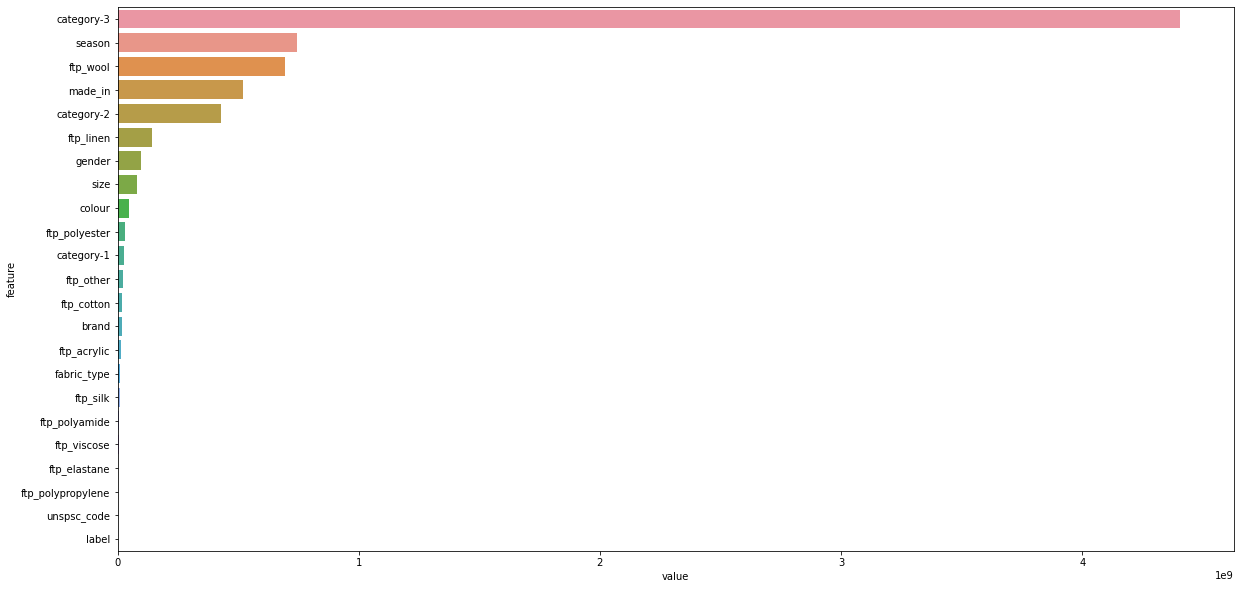

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = X.columns.tolist()

feature_imp = pd.DataFrame(
    sorted(zip(lgb_clf.feature_importance(importance_type="gain"), cols)),
    columns=["value", "feature"])

plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))

plt.savefig("features.png")


In [ ]:
def run_lgb_bayesian(num_leaves, max_depth, lambda_l1, lambda_l2, bagging_fraction, bagging_freq, colsample_bytree, learning_rate):
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 42,
        'num_leaves': int(num_leaves),
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': int(bagging_freq),
        'colsample_bytree': colsample_bytree,
        'verbose': 0
    }
    return run_lgb(X, y, params)

if True:
    from bayes_opt import BayesianOptimization

    bounds_lgb = {
        'num_leaves': (20, 300),
        'max_depth': (8, 12),
        'lambda_l1': (0, 5),
        'lambda_l2': (0, 5),
        'bagging_fraction': (0.4, 1),
        'bagging_freq': (1, 10),
        'colsample_bytree': (0.4, 1),
        'learning_rate': (0.025, 0.1),
    }

    lgb_bo = BayesianOptimization(run_lgb_bayesian, bounds_lgb, random_state = 42)
    lgb_bo.maximize(init_points = 20, n_iter = 20, acq = 'ucb', xi = 0.0, alpha = 1e-6)

    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 42,
        'num_leavs': lgb_bo.max['params']['num_leaves'],
        'learning_rate': lgb_bo.max['params']['learning_rate'],
        'max_depth': int(lgb_bo.max['params']['max_depth']),
        'lambda_l1': lgb_bo.max['params']['lambda_l1'],
        'lambda_l2': lgb_bo.max['params']['lambda_l2'],
        'bagging_fraction': lgb_bo.max['params']['bagging_fraction'],
        'bagging_freq': int(lgb_bo.max['params']['bagging_freq']),
        'colsample_bytree': lgb_bo.max['params']['colsample_bytree']
    }
    params